# Modelos de Mezclas de Gaussianas y Expectation Maximization

### GMM de 2 Gaussianas

Dadas dos distribuciones Normales: 
$$N(\mu_1, \sigma_1^2) \quad{_y}\quad N(\mu_2,\sigma_2^2)$$

Se deben estimar 5 parámateros:  
$$\theta = (w,\mu_1,\sigma_1^2,\mu_2,\sigma_2^2)$$  


donde  $w$  es la probabilidad que los datos provengan de la primera distribución y ($1- w$ ) que pertenezcan a la segunda distribución normal.


La función de densidad de probabilidad (FDP) del modelo de mezclas es:


$$f(x|\theta)=w f_1(x | \mu_1,\sigma_1^2)+(1−w) f_2(x | \mu_2,\sigma_2^2)$$

Siendo $f_1$ y $f_2$ las funciones de densidad de probabilidad de las distribuciones.

**Objetivo**: ajustar lo mejor posible una densidad de probabilidad dada encontrando mediante iteraciones EM los parámetros:   **$$\theta = (w,\mu_1,\sigma_1^2,\mu_2,\sigma_2^2)$$**

In [1]:
# Importar las librerías neccesarias:

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
from scipy import stats
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform

Generar un modelo GMM como una mezcla de 2 Gaussianas definidas por su media y desvío estándar.

La función de densidad de probabilidad de una gaussiana está dada por la siguiente fórmula:
$$f(x) = \frac{1}{|\sigma| \sqrt{2π}}e^{- \frac{(x-\mu)^2}{2\sigma^2}}$$

In [2]:
Mean1 = 2
Standard_dev1 = 4 
Mean2 = 12 
Standard_dev2 = 2 

# Sintetizar datos correspondientes a esas Gaussianas:
y1 = np.random.normal(Mean1, Standard_dev1, 1000)
y2 = np.random.normal(Mean2, Standard_dev2, 500)
data=np.append(y1,y2)

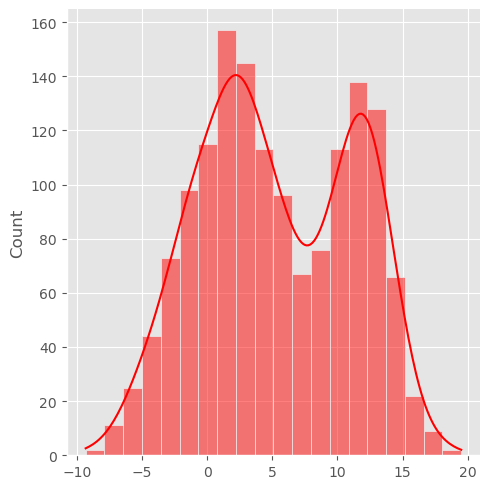

In [3]:
# Graficar las distribuciones de los datos sintetizados:
Min_graph = min(data)
Max_graph = max(data)

x = np.linspace(Min_graph, Max_graph, 2000)
sns.displot(data, bins=20, kde=True, color="red")

### Definir las Gaussianas 

In [4]:
class Gaussian:
    "Modelo de Gaussiana univariada"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    # función densidad de probabilidad
    def pdf(self, datum):
        "Probabilidad de un dato dado, según los parámetros actuales"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return f'Gaussiana(μ = {self.mu:.2}, σ = {self.sigma:.2})'

#### Encontrar una única Gaussiana que ajuste lo mejor posible a los datos:

In [5]:
g_single = Gaussian(np.mean(data), np.std(data))
print(g_single)

Gaussiana(μ = 5.3, σ = 5.8)


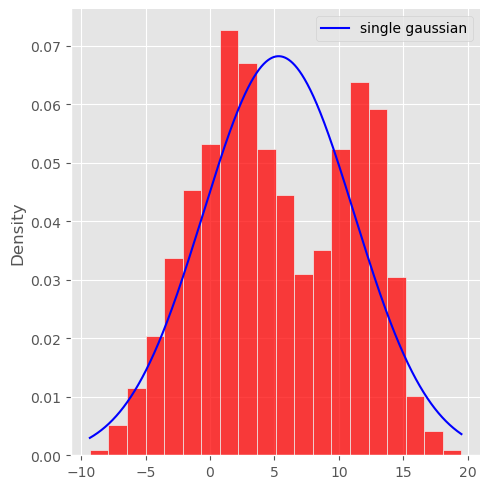

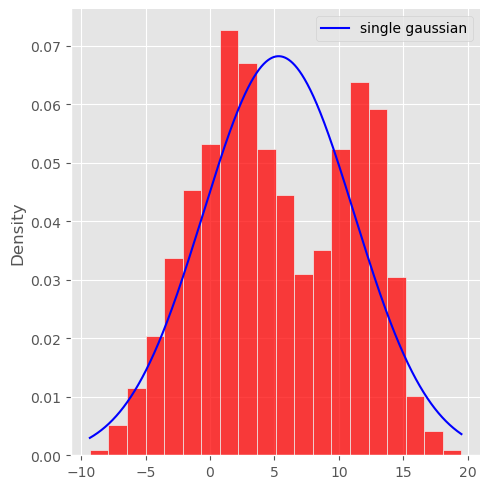

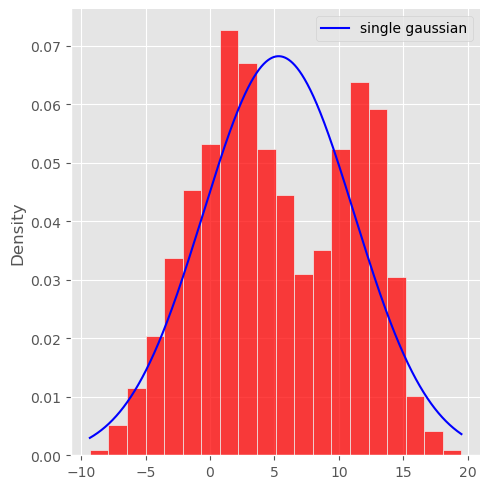

In [8]:
sns.displot(data, bins=20, kde=False, stat="density", color= "red")
y = [g_single.pdf(i) for i in x]
plt.plot(x, y, label='single gaussian', color = "blue")

plt.legend();
plt.show()

Claramente, viendo los datos nos damos cuenta de que una única distribución normal no es un buen modelo para ajustar a la distribución multimodal. En este caso, es mejor cambiar nuestro modelo por un modelo de mezcla compuesta por dos o más distribuciones.

### Algoritmo EM (Expectation Maximization)

Siguiendo esa idea, podemos asumir como hipótesis que hay $K$ componentes en el modelo de mezclas. Comenzamos eligiendo un componente $k$ con una cierta probabilidad $\pi_k$ y dado el componente elegido, elegimos una muestra $x$ de la distribución normal $\mathcal{N}(x\vert\mu_k, \sigma_k^2)$.

Podemos pensar que esa componente es una variable aleatoria discreta $\mathbf{z}$ que puede tomar valores de 1 a $K$. Por lo tanto, para cada muestra $x$ tenemos un valor asociado $\mathbf{z}$. Como no observamos $\mathbf{z}$, la llamamos **variable latentente**. Si agrupamos los parámetros $\pi_k$, $\mu_k$ y $\sigma_k$ en un solo parámetro $\boldsymbol{\theta}$, tenemos el siguiente modelo gráfico:

<center><img src="https://drive.google.com/uc?export=view&id=1rrGpwafN52bR9jA10mdyDgCJqHu6x5Kp" width=150 alt="centered image"></center>


Ese modelo refleja el hecho que cada observación tiene un valor asociado de variable latente. En la gráfica la variable $z$ aparece sin relleno  para denotar que no es observable.

Ahora podemos seguir buscando los parámetros de nuestro nuevo modelo, utilizando MLE (_Maximum Likelihood Estimate_ o máximo a posteriori, si tenemos probabilidades a priori sobre los parámetros). Sin embargo, como suele ocurrir, hemos cambiado trazabilidad por expresividad al introducir variables latentes. Si intentamos maximizar la log-likelihood, nos encontramos con que tenemos que maximizar

$$
\begin{align}
\sum_{n=1}^N\log \sum_{z}p(x_n\vert z_n, \boldsymbol{\theta})p(z_n\vert\boldsymbol{\theta})
\end{align}
$$

que debido al término de la sumatoria interior del logaritmo, no resulta en una solución de forma cerrada. Una alternativa es  usar el algoritmo de **Expectation Maximization**, un procedimiento iterativo para encontrar estimaciones de máxima verosimilitud de los parámetros.

Sean respectivamente $\mathbf{X}$ y $\mathbf{Z}$ el conjunto de variables observadas y latentes, para las cuales definimos una distribución de probabilidad paramétrica conjunta

$$
p(\mathbf{X}, \mathbf{Z}\vert\boldsymbol{\theta}) = p(\mathbf{X}\vert\mathbf{Z},\boldsymbol{\theta})p(\mathbf{Z}\vert\boldsymbol{\theta})
$$

Se puede demostrar que para cualquier distribución $q(\mathbf{Z})$ podemos descomponer el log-likelihood de la siguiente manera

$$
\log p(\mathbf{X}\vert\boldsymbol{\theta}) = \mathcal{L}(q, \boldsymbol{\theta}) + \text{KL}(q(\mathbf{Z})\Vert p(\mathbf{Z\vert\mathbf{X}, \boldsymbol{\theta}}))\tag{1}
$$

donde $\text{KL}$ es la divergencia Kullback-Leibler, y $\mathcal{L}(q,\boldsymbol{\theta})$ se conoce como Límite Inferior de Evidencia (ELBO), porque como la divergencia KL siempre es no negativa, es un límite inferior para $p(\mathbf{X}\vert\boldsymbol{\theta})$. El ELBO se define como

$$
\mathcal{L}(q, \boldsymbol{\theta}) = \mathbb{E}_q[\log p(\mathbf{X},\mathbf{Z}\vert\boldsymbol{\theta})] - \mathbb{E}_q[\log q(\mathbf{Z})]\tag{2}
$$

Esas esperanzas se calculan con respecto a la distribución $q(\mathbf{Z})$.

Ahora podemos usar esa descomposición en el algoritmo EM para definir dos pasos:

- **E:** Inicializar los parámetros con algún valor $\boldsymbol{\theta}^\prime$. En la ecuación 1, aproximar la distancia entre el límite inferior y la probabilidad haciendo que la divergencia KL sea igual a cero. Esto se consigue fijando  $q(\mathbf{Z})$ igual al posterior $p(\mathbf{Z}\vert\mathbf{X},\boldsymbol{\theta}^\prime)$, que generalmente implica usar el teorema de Bayes para calcular

  $$
  p(\mathbf{Z}\vert\mathbf{X},\boldsymbol{\theta}^\prime) =
  \frac{p(\mathbf{X}\vert\mathbf{Z},\boldsymbol{\theta}^\prime)p(\mathbf{Z}\vert\boldsymbol{\theta}^\prime)}{p(\mathbf{X}\vert\boldsymbol{\theta}^\prime)}
  $$

- **M:** ahora que el likelihood es igual al límite inferior, maximizarlo en la ecuación 2 con respecto a los parámetros. Encontramos

  $$
  \boldsymbol{\theta}^{\text{new}} = \arg\max_{\boldsymbol{\theta}} \mathbb{E}_q[\log p(\mathbf{X},\mathbf{Z}\vert\boldsymbol{\theta})]
  $$

  donde eliminamos el segundo término en la ecuación 2 ya que no es función de los parámetros, y la esperanza se calcula respecto a $q(\mathbf{Z}) = p(\mathbf{Z}\vert\mathbf{X},\boldsymbol{\theta}^\prime)$. En este paso calculamos las derivadas con respecto a los parámeros e igualamos a ceropara encontrar los valores para la maximización.

Ese proceso se repite hasta la convergencia.

**Algoritmo de EM**

Ajusta los parámetros de un modelo alternando de manera iterativa y sucesivamente dos operaciones:

- **Cálculo de Esperanza (paso E):** dados los parámetros actuales del modelo, estimar la distribución de probabilidades (crear función para la esperanza del log-likelihood).
- **Maximización (paso M):** dados los datos actuales, estimar los parámetros para actualizar el modelo, maximizando el log-likelihood esperado encontrado en el paso E.


Luego, las estimaciones de los parámetros M se utilizan para determinar la distribución de las variables latentes en el siguiente paso E.


**Pasos de EM**
- Inicializar los parámetros del modelo ($\theta$), aleatoriamente y calcular el valor inicial del log-likelihood.
- Paso E: Calcular los mejores valores para Z dado $\theta$. Encontrar las probabilidades a posteriori de la variable latente dados los valores de parámetros actuales 
$$γ(z_{nk}) = \frac{π_k\mathcal{N} (\mathbf{x}_n|µ_k, Σ_k)} {\sum^K_{j=1}π_j\mathcal{N} (\mathbf{x}_n|µ_j, \mathbf{Σ}j)}$$
- Paso M: Usar los valores calculados de Z para calcular una estimación más ajustada para $\theta$. Reestimar los parámetros dadas las probabilidades a posteriori actuales $γ(z_{nk})$:

$$\mathbf{\mu}_k^{new}=\frac{1}{N_k}\sum_{n=1}^{N}\gamma(z_{nk})\mathbf{x}_n$$

Es el promedio ponderado, por eso agrega el término gamma en la sumatoria

$$\mathbf{Σ}_k^{new} = \frac{1}{N_k}\sum^N_{n =1}γ(z_{nk})(\mathbf{x}_n - \mathbf{µ}_k^{new})(\mathbf{x}_n - \mathbf{µ}_k^{new})^T $$


$$\pi_k^{new}=\frac{N_k}{N}$$

Donde: 
$$N_k=\sum_{n=1}^{N}\gamma(z_{nk})$$

Podemos interpretar a $N_k$ como el número de puntos asignados al cluster $k$. Vemos que la media $\mathbf{\mu}_k$ para el k-ésimo componente gaussianna se obtiene tomando una media ponderada de todos los puntos del conjunto de datos, donde el factor de ponderación para cada punto $x_n$ está dado por la probabilidad posterior $γ(z_{nk})$.

La probabilidad posterior $γ(z_{nk})$ es la estimación de la probabilidad de que el punto de datos $x_n$ pertenezca a la k-ésima componente Gaussiana, dada la observación de los datos y los parámetros actuales del modelo.

- Iterar los pasos 2 y 3 hasta la convergencia. Monitorear la función de log likelihood

$$\mathbf{\log} p(\mathbf{X}|\mathbf{\mu}, \mathbf{\Sigma}, \mathbf{\pi} ) = \sum_{n=1}^{N}\log \bigg\{\sum_{k=1}^{K}\pi_k\mathcal{N}(\mathbf{x}_n|\mathbf{\mu}_k,\mathbf{\Sigma}_k) \bigg\}$$


### Definir el modelo GMM con el algoritmo EM

In [9]:
class GaussianMixture:
    "Modelo de mezclas de 2 Gaussianas univariadas y sus estimaciones mediante EM"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        #inicialización de las 2 gaussianas
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #coeficientes de mezcla
        self.mix = mix

    def Estep(self):
        "Paso E(speranza), refrescando el self.loglike en el proceso"
        # calcular pesos
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Paso M(aximización)"
        # calcular los denominadores
        (left, right) = zip(*weights)
        one_den = sum(left)
        two_den = sum(right)
        # calcular las nuevas medias
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(right, data))
        # calcular los nuevos sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(right, data)) / two_den)
        # calcular la mezcla
        self.mix = one_den / len(data)

    def iterate(self, N=1, verbose=False):
        "Hacer N iteraciones y luego calcular el log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #El corazón del algoritmo, realiza el paso E y después el M
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep()

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

In [11]:
# Checkeo del proceso de ajuste
n_iterations = 10
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Detecta errores de división de las malas salidas, y los descarta
        pass

 1 Mixture: Gaussiana(μ = 7.7, σ = 4.5), Gaussiana(μ = -2.2, σ = 2.0), mix=0.762)
 1 Mixture: Gaussiana(μ = 7.4, σ = 4.9), Gaussiana(μ = -1.8, σ = 2.3), mix=0.773)
 1 Mixture: Gaussiana(μ = 7.3, σ = 5.0), Gaussiana(μ = -1.4, σ = 2.5), mix=0.771)
 1 Mixture: Gaussiana(μ = 7.3, σ = 5.1), Gaussiana(μ = -1.2, σ = 2.6), mix=0.765)
 1 Mixture: Gaussiana(μ = 7.4, σ = 5.1), Gaussiana(μ = -1.0, σ = 2.7), mix=0.757)
 1 Mixture: Gaussiana(μ = 7.4, σ = 5.1), Gaussiana(μ = -0.86, σ = 2.7), mix=0.748)
 1 Mixture: Gaussiana(μ = 7.5, σ = 5.1), Gaussiana(μ = -0.75, σ = 2.8), mix=0.739)
 1 Mixture: Gaussiana(μ = 7.5, σ = 5.1), Gaussiana(μ = -0.67, σ = 2.8), mix=0.73)
 1 Mixture: Gaussiana(μ = 7.6, σ = 5.0), Gaussiana(μ = -0.6, σ = 2.8), mix=0.72)
 1 Mixture: Gaussiana(μ = 7.7, σ = 5.0), Gaussiana(μ = -0.54, σ = 2.9), mix=0.711)


In [12]:
# Encontrar el mejor modelo de mezcla Gaussiana
n_iterations = 300
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Cálculo del mejor modelo con reinicios aleatorios...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate(verbose=False)
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Detecta errores de división por malas inicializaciones y los descarta
            pass
print('Mejor Mezcla de Gaussianas : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))


Cálculo del mejor modelo con reinicios aleatorios...

Mejor Mezcla de Gaussianas : μ = 1.9, σ = 3.9 with μ = 1.2e+01, σ = 2.1


Mostrar el resultado

<Figure size 1200x600 with 0 Axes>

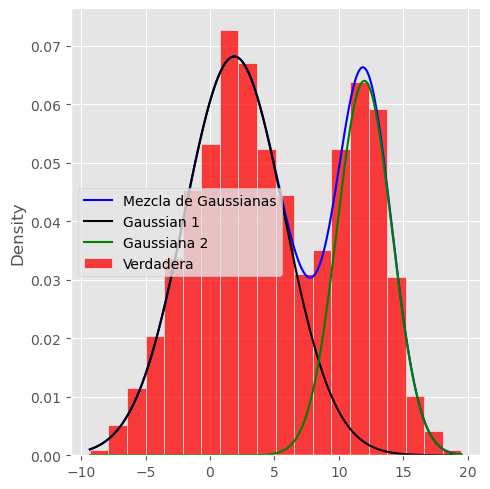

<Figure size 1200x600 with 0 Axes>

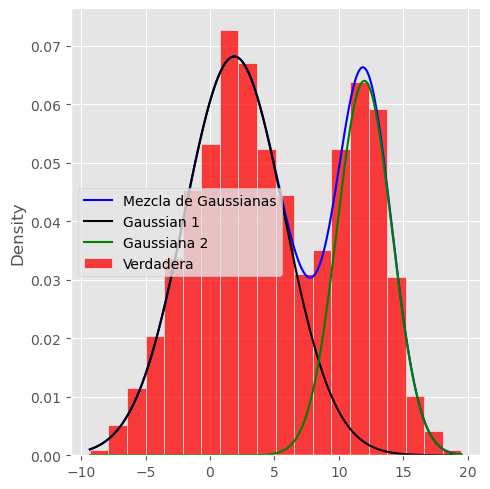

In [14]:
plt.figure(figsize = (12,6))
sns.displot(data, bins=20, kde=False, stat="density", label= "Verdadera", color="r")
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='Mezcla de Gaussianas', color = "b");
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='Gaussian 1', color ="black");
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='Gaussiana 2', color = "green");
plt.legend();
plt.show()